In [89]:
from psaw import PushshiftAPI
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import datetime
import os
from itertools import islice
from collections import defaultdict
import networkx as nx

# Get data

Every submission on r/news, r/television or r/worldnews beteewn the 2022Oscars and the 18th of april with any of the following:
slap, Will Smith, Chris Rock, Oscars.
Has been downloaded.

Every comment has been downloaded from the above submissions.

News about people slapping with no contaxt to the Oscars may have been downlaoded.

In [5]:
subreddits = ['news', 'television', 'worldnews']#, 'USnews','qualitynews', 'offbeat', 'OutOfTheLoop', 'Oscars', 'boxoffice', 'willsmith', 'entertainment' ]
    
query = 'slap|Will Smith|Chris Rock|chris rock|will smith|Oscars|oscars'.replace('|', ' | ')

fields = ['author', 'author_fullname', 'created_utc', 'id', 'num_comments',
          'score', 'subreddit', 'subreddit_id', 'title', 'upvote_ratio']

start_time = int(datetime.datetime(2022,3,28).timestamp()) # Oscars started midnight UTC
end_time = int(datetime.datetime(2022,4,18).timestamp())


In [6]:
print(start_time)
if not os.path.exists('./data/submissions.csv'):
    data_submissions = pd.DataFrame(columns=fields + ['created'])
    data_submissions.to_csv('./data/submissions.csv', index=False)
else:
    data_submissions = pd.read_csv('./data/submissions.csv')
    if len(data_submissions['created_utc']):
        start_time = max(data_submissions['created_utc']) + 1 # override start_time here
print(start_time)


1648418400
1648418400


In [7]:
api = PushshiftAPI()

submission_generator = api.search_submissions(subreddit=','.join(subreddits),
                                              after=start_time,
                                              before=end_time,
                                              q=query,
                                              fields=fields)

# temp_df = pd.DataFrame([obj.d_ for obj in submission_generator])

In [8]:
save_n_subs_at_the_time = 100

while True:
    generator_sliced = islice(submission_generator, save_n_subs_at_the_time)
    
    temp_df = pd.DataFrame([obj.d_ for obj in generator_sliced])
    temp_df.to_csv('./data/submissions.csv', mode='a', index=False, header=False)
    
    if len(temp_df) != save_n_subs_at_the_time:
        break

In [9]:
data_submissions = pd.read_csv('./data/submissions.csv')
print(len(data_submissions))



683


In [ ]:
comment_fields = ['author', 'body', 'controversiality', 'created_utc',
                  'id', 'link_id', 'parent_id', 'score', 'score_hidden', 'subreddit', 'subreddit_id']
last_id_index = 0

if not os.path.exists('./data/comments.csv'):
    df_comments = pd.DataFrame(columns=comment_fields + ['created', 'post_link_id'])
    df_comments.to_csv('./data/comments.csv', index=False)
else:
    old_df = pd.read_csv('./data/comments.csv')
    last_id = old_df['post_link_id'][len(old_df) - 1]
    last_id_index = np.where(data_submissions['id'] == last_id)[0][0] + 1
    
print(f'{len(data_submissions)} submissions in total')
for row in tqdm(data_submissions[['subreddit', 'id']][last_id_index:].iterrows()):
    subreddit, id = row[1]
    
    comments_generator = api.search_comments(subreddit=subreddit,
                                             link_id=id,
                                             fields=comment_fields)
    
    temp_df = pd.DataFrame([obj.d_ for obj in comments_generator])
    temp_df['post_link_id'] = [id] * len(temp_df)
    
    temp_df.to_csv('./data/comments.csv', mode='a', index=False, header=False)

In [26]:
data_comments = pd.read_csv('./data/comments.csv')
len(data_comments)

74307

# Data analyzis

Text(0.5, 1.0, 'Number of comments pr day')

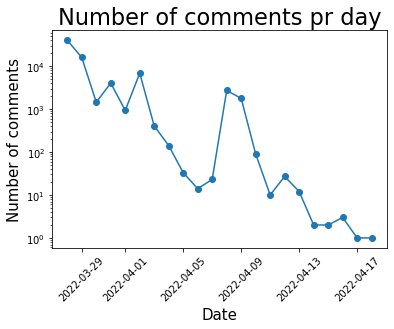

In [74]:
labelsize = 15
title_size = labelsize*1.5

data_comments['Datetime'] = pd.to_datetime(data_comments['created_utc'] + np.random.rand(len(data_comments))*0.01, unit='s')
temp = data_comments.set_index('Datetime')
temp['count'] = np.ones(len(temp))
freq = temp.resample('D').sum()['count']
plt.semilogy(freq,'-o')
plt.xticks(rotation=45, rotation_mode = 'default')
plt.xlabel('Date', fontsize = labelsize)
plt.ylabel('Number of comments', fontsize = labelsize)
plt.title('Number of comments pr day', fontsize = title_size)


In [76]:
data_comments.columns

Index(['author', 'body', 'controversiality', 'created_utc', 'id', 'link_id',
       'parent_id', 'score', 'score_hidden', 'subreddit', 'subreddit_id',
       'created', 'post_link_id', 'Datetime'],
      dtype='object')

In [100]:
data_comments

,author,body,controversiality,created_utc,id,link_id,parent_id,score,score_hidden,subreddit,subreddit_id,created,post_link_id,Datetime
0,[deleted],[removed],0,1649769321,i4fa17l,t3_u1ybvn,t3_u1ybvn,1,True,news,t5_2qh3l,1.649762e+09,u1ybvn,2022-04-12 13:15:21.005492992
1,Avante-Gardenerd,Who wrote this headline? What the actual fuck?,0,1649769253,i4f9von,t3_u1ybvn,t3_u1ybvn,1,True,news,t5_2qh3l,1.649762e+09,u1ybvn,2022-04-12 13:14:13.002993152
2,IamChooch,CNN reported it was Trump's fault. Will must o...,0,1649769204,i4f9rua,t3_u1ybvn,t1_i4f7mq1,1,True,news,t5_2qh3l,1.649762e+09,u1ybvn,2022-04-12 13:13:24.002057472
3,[deleted],[removed],0,1649768969,i4f996c,t3_u1ybvn,t3_u1ybvn,1,True,news,t5_2qh3l,1.649762e+09,u1ybvn,2022-04-12 13:09:29.003690752
4,[deleted],[removed],0,1649768846,i4f8zno,t3_u1ybvn,t1_i4f7mq1,1,True,news,t5_2qh3l,1.649762e+09,u1ybvn,2022-04-12 13:07:26.000074752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74302,gnrc,Will Smith has lost his g dang mind.,0,1648435004,i2e2zpc,t3_tpz9w3,t3_tpz9w3,1,False,television,t5_2qh6e,1.648428e+09,tpz9w3,2022-03-28 02:36:44.003276544
74303,justice4juicy2020,Just came to post this. Theres a more clear v...,0,1648435001,i2e2zi6,t3_tpz9w3,t3_tpz9w3,1,False,television,t5_2qh6e,1.648428e+09,tpz9w3,2022-03-28 02:36:41.008706560
74304,JesusChristSuperDerp,i busted yo wife,0,1648434994,i2e2z0f,t3_tpz9w3,t3_tpz9w3,1,False,television,t5_2qh6e,1.648428e+09,tpz9w3,2022-03-28 02:36:34.009012480
74305,Goose_Dickling,This was fucking crazy,0,1648434959,i2e2wjn,t3_tpz9w3,t3_tpz9w3,1,False,television,t5_2qh6e,1.648428e+09,tpz9w3,2022-03-28 02:35:59.006312704


In [91]:
data_comments

get_author = {row['id']: row['author'] for _,row in tqdm(data_comments.iterrows())}

In [144]:
connections = defaultdict(int)
i=0
for _,row in data_comments.iterrows():
    try: connections[row['author'],get_author[row['parent_id'][3:]]] += 1
    except KeyError:
        i += 1
edges = [(row[1],row[0], connections[row[1],row[0]] + connections[row[0],row[1]]) for row in connections if (row[0],row[1]) in connections and (row[1],row[0]) in connections]

print('number of removed comments due to errors', i)


number of removed user due to errors 18400


In [114]:
G = nx.Graph()

for u,v,w in edges:
    G.add_edge(u,v,weight = w)

In [115]:
print(G.number_of_nodes())
print(G.number_of_edges())

6863
5623


Text(0.5, 1.0, 'Degree distribution')

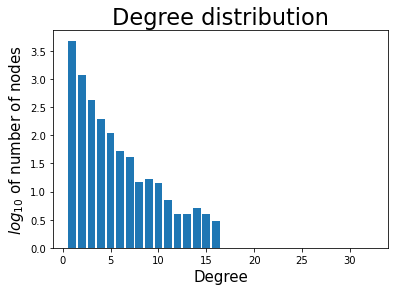

In [143]:
degrees = list(dict(G.degree()).values())
degree_dist = defaultdict(int)
for d in degrees:
    degree_dist[d] += 1

sorted(tuple(degree_dist.items()))

plt.bar(degree_dist.keys(), np.log10(list(degree_dist.values())))
plt.xlabel('Degree', fontsize = labelsize)
plt.ylabel('$log_{10}$ of number of nodes', fontsize = labelsize)
plt.title('Degree distribution', fontsize = title_size)
